# Deep Learning Experiments on CIFAR-10


*   Name - Gaurav Sharan
*   Registration Number - 20MIA1081







In [1]:
!pip install torch torchvision wandb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # For activation functions
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import wandb
import time
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Log in to Weights & Biases
wandb.login()


Using device: cuda


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: g22168559 (g22168559-vellore-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
class BasicBlock(nn.Module):
    expansion = 1  # For basic block the expansion factor is 1

    def __init__(self, in_planes, planes, stride=1):
        """
        A basic residual block for ResNet‑32.
        Args:
          in_planes: Number of input channels.
          planes: Number of output channels.
          stride: Stride for the first convolution.
        """
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        # Define the shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet32(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        """
        Constructs a ResNet‑32 model for CIFAR‑10.
        Args:
          block: Block type (BasicBlock).
          num_blocks: A list specifying how many blocks each layer should have (for ResNet-32, this would be [5, 5, 5]).
          num_classes: Number of output classes (10 for CIFAR‑10).
        """
        super(ResNet32, self).__init__()
        self.in_planes = 16

        # Initial convolution layer (3×3 conv for CIFAR‑10)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        # Creating three layers (groups) of residual blocks
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)

        # Global average pooling and final fully connected layer
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        """
        Creates one group (layer) of residual blocks.
        """
        strides = [stride] + [1]*(num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # Global average pooling over spatial dimensions
        out = F.avg_pool2d(out, out.size(3))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def get_resnet32_for_cifar10():
    """
    Instantiates a ResNet‑32 model for CIFAR‑10.
    For ResNet‑32, we use 5 residual blocks per layer: [5, 5, 5].
    Returns:
      model (nn.Module): A ResNet‑32 model.
    """
    return ResNet32(BasicBlock, [5, 5, 5], num_classes=10)


In [4]:
def train_one_epoch(model, optimizer, criterion, train_loader, device):
    """
    Trains the model for one epoch.

    Args:
      model (nn.Module): Model to train.
      optimizer: Optimizer.
      criterion: Loss function.
      train_loader (DataLoader): Training data loader.
      device: CPU or GPU.

    Returns:
      epoch_loss (float): Average training loss.
      epoch_acc (float): Training accuracy.
    """
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, criterion, loader, device):
    """
    Evaluates the model on a validation/test set.

    Args:
      model (nn.Module): Model to evaluate.
      criterion: Loss function.
      loader (DataLoader): Validation/test data loader.
      device: CPU or GPU.

    Returns:
      epoch_loss (float): Average loss.
      epoch_acc (float): Accuracy.
    """
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [5]:
def run_experiment(config=None):
    """
    Runs a single experiment with the given hyperparameters.
    - Each experiment gets logged as a separate run on W&B.
    - Checkpoints are saved at the end of each epoch with unique filenames and uploaded.
    - Optionally, a MultiStepLR scheduler can be used if specified.

    Args:
      config (dict): A dictionary containing the hyperparameters for the experiment.

    Returns:
      model (nn.Module): The trained model after the experiment.
      test_loader (DataLoader): The DataLoader for the test dataset, ready for evaluation.
    """
    with wandb.init(project="cifar10_classification_Data_science_assignment_Tata_communication", config=config) as run:
        config = wandb.config

        # Data transformations for training and testing
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
        ])

        # Download CIFAR-10 dataset
        train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
        test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

        # Create a train/validation split (80% train, 20% validation)
        num_train = int(0.8 * len(train_dataset))
        num_val = len(train_dataset) - num_train
        train_subset, val_subset = torch.utils.data.random_split(train_dataset, [num_train, num_val])

        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=config.batch_size, shuffle=True, num_workers=2)
        val_loader   = torch.utils.data.DataLoader(val_subset, batch_size=config.batch_size, shuffle=False, num_workers=2)
        test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)

        # Initialize the ResNet-32 model for CIFAR-10
        model = get_resnet32_for_cifar10().to(device)

        # Define the loss function
        criterion = nn.CrossEntropyLoss()

        # Select the optimizer based on configuration
        if config.optimizer.lower() == "sgd":
            optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=0.9, weight_decay=5e-4)
        elif config.optimizer.lower() == "adam":
            optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=5e-4)
        else:
            raise ValueError("Unsupported optimizer type. Please choose 'sgd' or 'adam'.")

        # Optionally, set up a learning rate scheduler
        scheduler = None
        if hasattr(config, "use_scheduler") and config.use_scheduler:
            # Decay learning rate at 50% and 75% of total epochs
            milestones = [int(config.epochs * 0.5), int(config.epochs * 0.75)]
            scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

        best_val_acc = 0.0  # To track the best validation accuracy

        # Training loop for the specified number of epochs
        for epoch in range(config.epochs):
            train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_loader, device)
            val_loss, val_acc = validate(model, criterion, val_loader, device)

            # Log metrics to W&B for the current epoch
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "learning_rate": optimizer.param_groups[0]['lr'],
                "optimizer": config.optimizer
            })

            print(f"Epoch [{epoch+1}/{config.epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            # Save every epoch's checkpoint with a unique filename
            checkpoint_filename = f"{wandb.run.id}_epoch_{epoch+1}_{int(time.time())}.pth"
            torch.save(model.state_dict(), checkpoint_filename)
            wandb.save(checkpoint_filename)

            # Optionally, save the best model checkpoint separately if validation accuracy improves
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_checkpoint = f"{wandb.run.id}_best_epoch_{epoch+1}_{int(time.time())}.pth"
                torch.save(model.state_dict(), best_checkpoint)
                wandb.save(best_checkpoint)

            # Step the learning rate scheduler, if used
            if scheduler is not None:
                scheduler.step()

        # After training, evaluate the model on the test set
        test_loss, test_acc = validate(model, criterion, test_loader, device)
        wandb.log({"test_loss": test_loss, "test_acc": test_acc})
        print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

        # Return the trained model and test_loader for further analysis if needed
        return model, test_loader


In [6]:
# Define six hyperparameter configurations
experiment_configs = [

    {"epochs": 10, "batch_size": 128, "learning_rate": 0.001, "optimizer": "adam"},
    {"epochs": 10, "batch_size": 128, "learning_rate": 0.5, "optimizer": "adam"},
    {"epochs": 15, "batch_size": 128, "learning_rate": 0.0001, "optimizer": "adam"},
    {"epochs": 10, "batch_size": 128, "learning_rate": 0.001, "optimizer": "sgd"},
    {"epochs": 20, "batch_size": 128, "learning_rate": 0.0005, "optimizer": "sgd"},
    {"epochs": 105, "batch_size": 128, "learning_rate": 0.1, "optimizer": "sgd", "use_scheduler": True}
]

# Run each experiment sequentially
for config in experiment_configs:
    print("\nStarting experiment with configuration:")
    print(config)
    run_experiment(config)



Starting experiment with configuration:
{'epochs': 10, 'batch_size': 128, 'learning_rate': 0.001, 'optimizer': 'adam'}


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


100%|██████████| 170M/170M [00:03<00:00, 44.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch [1/10] | Train Loss: 1.5607 | Train Acc: 0.4196 | Val Loss: 1.3287 | Val Acc: 0.5241
Epoch [2/10] | Train Loss: 1.1281 | Train Acc: 0.5965 | Val Loss: 1.1918 | Val Acc: 0.5735
Epoch [3/10] | Train Loss: 0.9390 | Train Acc: 0.6670 | Val Loss: 0.9930 | Val Acc: 0.6483
Epoch [4/10] | Train Loss: 0.8159 | Train Acc: 0.7138 | Val Loss: 1.0505 | Val Acc: 0.6488
Epoch [5/10] | Train Loss: 0.7365 | Train Acc: 0.7419 | Val Loss: 0.8432 | Val Acc: 0.7074
Epoch [6/10] | Train Loss: 0.6712 | Train Acc: 0.7670 | Val Loss: 0.7309 | Val Acc: 0.7475
Epoch [7/10] | Train Loss: 0.6288 | Train Acc: 0.7812 | Val Loss: 0.7598 | Val Acc: 0.7365
Epoch [8/10] | Train Loss: 0.5941 | Train Acc: 0.7937 | Val Loss: 0.6918 | Val Acc: 0.7633
Epoch [9/10] | Train Loss: 0.5747 | Train Acc: 0.8022 | Val Loss: 0.7910 | Val Acc: 0.7344
Epoch [10/10] | Train Loss: 0.5402 | Train Acc: 0.8125 | Val Loss: 0.6486 | Val Acc: 0.7800


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▂▄▄▆▇▇█▇█
val_loss,█▇▅▅▃▂▂▁▂▁
epoch,10
learning_rate,0.001
optimizer,adam



Starting experiment with configuration:
{'epochs': 10, 'batch_size': 128, 'learning_rate': 0.5, 'optimizer': 'adam'}


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10] | Train Loss: 2.7467 | Train Acc: 0.1236 | Val Loss: 13.9765 | Val Acc: 0.0773
Epoch [2/10] | Train Loss: 2.4944 | Train Acc: 0.1225 | Val Loss: 2.3877 | Val Acc: 0.0963
Epoch [3/10] | Train Loss: 2.3989 | Train Acc: 0.1147 | Val Loss: 2.3170 | Val Acc: 0.1156
Epoch [4/10] | Train Loss: 2.4777 | Train Acc: 0.1135 | Val Loss: 2.3586 | Val Acc: 0.1025
Epoch [5/10] | Train Loss: 2.3951 | Train Acc: 0.1066 | Val Loss: 2.3517 | Val Acc: 0.0641
Epoch [6/10] | Train Loss: 2.3794 | Train Acc: 0.1075 | Val Loss: 2.4053 | Val Acc: 0.0995
Epoch [7/10] | Train Loss: 2.5382 | Train Acc: 0.1058 | Val Loss: 38.1255 | Val Acc: 0.0995
Epoch [8/10] | Train Loss: 2.3597 | Train Acc: 0.1151 | Val Loss: 54.7649 | Val Acc: 0.0995
Epoch [9/10] | Train Loss: 2.5252 | Train Acc: 0.1039 | Val Loss: 197.2013 | Val Acc: 0.1006
Epoch [10/10] | Train Loss: 2.5966 | Train Acc: 0.1114 | Val Loss: 2.3267 | Val Acc: 0.1023
Test Los

epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,██▅▄▂▂▂▅▁▄
train_loss,█▃▂▃▂▁▄▁▄▅
val_acc,▃▅█▆▁▆▆▆▆▆
val_loss,▁▁▁▁▁▁▂▃█▁
epoch,10
learning_rate,0.5
optimizer,adam



Starting experiment with configuration:
{'epochs': 15, 'batch_size': 128, 'learning_rate': 0.0001, 'optimizer': 'adam'}


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/15] | Train Loss: 1.7831 | Train Acc: 0.3430 | Val Loss: 1.5681 | Val Acc: 0.4133
Epoch [2/15] | Train Loss: 1.4445 | Train Acc: 0.4733 | Val Loss: 1.3780 | Val Acc: 0.4923
Epoch [3/15] | Train Loss: 1.2796 | Train Acc: 0.5356 | Val Loss: 1.2704 | Val Acc: 0.5387
Epoch [4/15] | Train Loss: 1.1639 | Train Acc: 0.5821 | Val Loss: 1.1740 | Val Acc: 0.5818
Epoch [5/15] | Train Loss: 1.0741 | Train Acc: 0.6165 | Val Loss: 1.1268 | Val Acc: 0.5934
Epoch [6/15] | Train Loss: 1.0006 | Train Acc: 0.6453 | Val Loss: 1.0207 | Val Acc: 0.6367
Epoch [7/15] | Train Loss: 0.9428 | Train Acc: 0.6623 | Val Loss: 0.9918 | Val Acc: 0.6450
Epoch [8/15] | Train Loss: 0.8908 | Train Acc: 0.6841 | Val Loss: 0.9442 | Val Acc: 0.6616
Epoch [9/15] | Train Loss: 0.8510 | Train Acc: 0.7001 | Val Loss: 0.9360 | Val Acc: 0.6732
Epoch [10/15] | Train Loss: 0.8108 | Train Acc: 0.7134 | Val Loss: 0.8827 | Val Acc: 0.6913
Epoch [11/15]

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▃▄▅▆▆▆▇▇▇▇████
train_loss,█▆▅▄▄▃▃▂▂▂▂▁▁▁▁
val_acc,▁▃▄▅▅▆▆▆▇▇▇▇███
val_loss,█▆▅▅▄▃▃▃▃▂▂▂▂▁▁
epoch,15
learning_rate,0.0001
optimizer,adam



Starting experiment with configuration:
{'epochs': 10, 'batch_size': 128, 'learning_rate': 0.001, 'optimizer': 'sgd'}


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10] | Train Loss: 1.8860 | Train Acc: 0.2881 | Val Loss: 1.6320 | Val Acc: 0.3818
Epoch [2/10] | Train Loss: 1.5239 | Train Acc: 0.4301 | Val Loss: 1.4967 | Val Acc: 0.4501
Epoch [3/10] | Train Loss: 1.3725 | Train Acc: 0.4953 | Val Loss: 1.3748 | Val Acc: 0.5082
Epoch [4/10] | Train Loss: 1.2427 | Train Acc: 0.5482 | Val Loss: 1.2251 | Val Acc: 0.5586
Epoch [5/10] | Train Loss: 1.1248 | Train Acc: 0.5962 | Val Loss: 1.1179 | Val Acc: 0.6009
Epoch [6/10] | Train Loss: 1.0297 | Train Acc: 0.6330 | Val Loss: 1.0518 | Val Acc: 0.6277
Epoch [7/10] | Train Loss: 0.9576 | Train Acc: 0.6574 | Val Loss: 0.9563 | Val Acc: 0.6633
Epoch [8/10] | Train Loss: 0.8885 | Train Acc: 0.6841 | Val Loss: 0.9854 | Val Acc: 0.6548
Epoch [9/10] | Train Loss: 0.8413 | Train Acc: 0.7038 | Val Loss: 0.8415 | Val Acc: 0.6992
Epoch [10/10] | Train Loss: 0.7926 | Train Acc: 0.7200 | Val Loss: 0.8643 | Val Acc: 0.6997
Test Loss: 0.

epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▃▄▅▆▇▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▅▆▆▇▇██
val_loss,█▇▆▄▃▃▂▂▁▁
epoch,10
learning_rate,0.001
optimizer,sgd



Starting experiment with configuration:
{'epochs': 20, 'batch_size': 128, 'learning_rate': 0.0005, 'optimizer': 'sgd'}


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20] | Train Loss: 1.9825 | Train Acc: 0.2519 | Val Loss: 1.7715 | Val Acc: 0.3221
Epoch [2/20] | Train Loss: 1.6530 | Train Acc: 0.3734 | Val Loss: 1.5896 | Val Acc: 0.3942
Epoch [3/20] | Train Loss: 1.5013 | Train Acc: 0.4405 | Val Loss: 1.4468 | Val Acc: 0.4643
Epoch [4/20] | Train Loss: 1.3795 | Train Acc: 0.4901 | Val Loss: 1.4054 | Val Acc: 0.4885
Epoch [5/20] | Train Loss: 1.2935 | Train Acc: 0.5258 | Val Loss: 1.3021 | Val Acc: 0.5268
Epoch [6/20] | Train Loss: 1.2213 | Train Acc: 0.5541 | Val Loss: 1.2355 | Val Acc: 0.5511
Epoch [7/20] | Train Loss: 1.1632 | Train Acc: 0.5786 | Val Loss: 1.1261 | Val Acc: 0.5913
Epoch [8/20] | Train Loss: 1.1084 | Train Acc: 0.5994 | Val Loss: 1.1085 | Val Acc: 0.6000
Epoch [9/20] | Train Loss: 1.0574 | Train Acc: 0.6197 | Val Loss: 1.0578 | Val Acc: 0.6151
Epoch [10/20] | Train Loss: 1.0183 | Train Acc: 0.6338 | Val Loss: 1.0684 | Val Acc: 0.6129
Epoch [11/20]

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇█████
train_loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
val_acc,▁▂▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
val_loss,█▇▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁
epoch,20
learning_rate,0.0005
optimizer,sgd



Starting experiment with configuration:
{'epochs': 105, 'batch_size': 128, 'learning_rate': 0.1, 'optimizer': 'sgd', 'use_scheduler': True}


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/105] | Train Loss: 1.7345 | Train Acc: 0.3479 | Val Loss: 1.4564 | Val Acc: 0.4609
Epoch [2/105] | Train Loss: 1.3230 | Train Acc: 0.5144 | Val Loss: 1.2047 | Val Acc: 0.5743
Epoch [3/105] | Train Loss: 1.0784 | Train Acc: 0.6136 | Val Loss: 1.1107 | Val Acc: 0.6126
Epoch [4/105] | Train Loss: 0.9124 | Train Acc: 0.6769 | Val Loss: 1.0348 | Val Acc: 0.6317
Epoch [5/105] | Train Loss: 0.8011 | Train Acc: 0.7207 | Val Loss: 1.0380 | Val Acc: 0.6400
Epoch [6/105] | Train Loss: 0.7300 | Train Acc: 0.7458 | Val Loss: 0.8585 | Val Acc: 0.7102
Epoch [7/105] | Train Loss: 0.6760 | Train Acc: 0.7659 | Val Loss: 0.8318 | Val Acc: 0.7099
Epoch [8/105] | Train Loss: 0.6450 | Train Acc: 0.7783 | Val Loss: 1.0066 | Val Acc: 0.6795
Epoch [9/105] | Train Loss: 0.6191 | Train Acc: 0.7875 | Val Loss: 0.7914 | Val Acc: 0.7306
Epoch [10/105] | Train Loss: 0.5966 | Train Acc: 0.7938 | Val Loss: 0.8744 | Val Acc: 0.6986
Epo

epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇████
learning_rate,█████████████████████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇██████████████████
train_loss,█▇▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▃▃▃▅▄▄▄▅▅▅▅▆▄▅████████████████████████
val_loss,█▇▅▆▅▄▅█▄▄▄▄▅▅▆▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,105
learning_rate,0.001
optimizer,sgd


In [6]:
import torch

# Initialize the model architecture (must match the saved model's architecture)
model = get_resnet32_for_cifar10().to(device)


model.load_state_dict(torch.load("/content/wgxixpiq_best_epoch_103_1738478116.pth", map_location=device))
model.eval()  # Set to evaluation mode

print("Model successfully loaded and ready for predictions!")


Model successfully loaded and ready for predictions!


<ipython-input-6-38e180de7191>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/wgxixpiq_best_epoch_103_1738478116.pth", map_locat

In [7]:
import torchvision
import torchvision.transforms as transforms
import torch


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])


test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

print(" Test dataset loaded successfully!")


100%|██████████| 170M/170M [00:08<00:00, 21.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
 Test dataset loaded successfully!


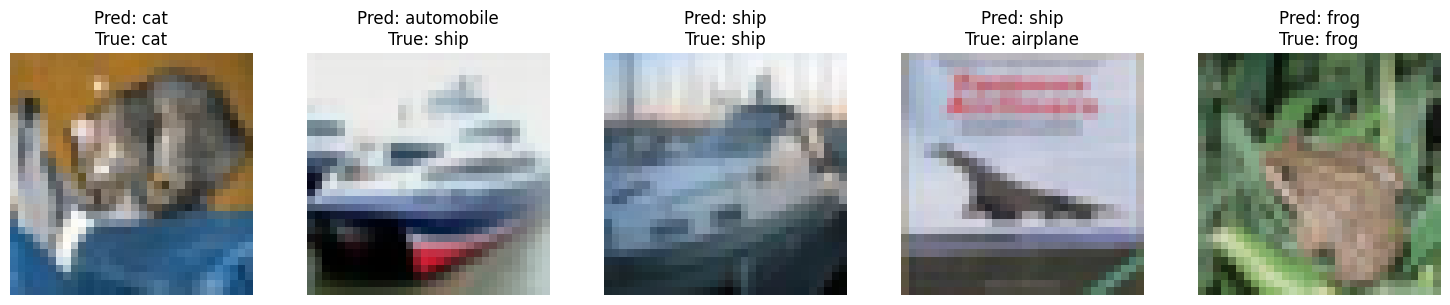

In [19]:
#  CIFAR-10 class names
cifar10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck']

# Run the prediction function
visualize_predictions(model, test_loader, cifar10_class_names, num_images=5)


# Analysis and Insights Report

## 1. Overview
This report analyzes the **CIFAR-10 classification task using ResNet-32**, trained across multiple experiments with different hyperparameters. The experiments were logged in **Weights & Biases (W&B)**, allowing a detailed comparison of training progress, model performance, and optimization strategies.

### Key Performance Metrics:
| Run Name          | Optimizer | Learning Rate | Epochs | Test Accuracy | Train Accuracy | Validation Accuracy |
|------------------|-----------|--------------|--------|--------------|--------------|-------------------|
| lucky-lion-6     | SGD       | 0.1          | 105    | 92.02%       | 99.38%       | 91.63%            |
| sage-brook-5     | SGD       | 0.0005       | 20     | 71.14%       | 75.24%       | 71.80%            |
| gallant-deluge-4 | SGD       | 0.001        | 10     | 70.22%       | 79.26%       | 69.97%            |
| rare-leaf-3      | Adam      | 0.0001       | 15     | 74.35%       | 76.75%       | 73.81%            |
| wobbly-snowflake-2 | Adam    | 0.5          | 10     | 10.23%       | 11.13%       | 10.23%            |
| restful-river-1  | Adam      | 0.001        | 10     | 78.25%       | 81.25%       | 78.00%            |

---

## 2. Experiment Comparisons Using W&B Dashboards
### Key Observations from W&B Graphs:
- Higher learning rates (0.5) led to unstable training, as seen in `wobbly-snowflake-2` with only 10% accuracy.
- SGD with LR scheduling (`lucky-lion-6`) showed the best performance with a final test accuracy of **92.02%**.
- Adam optimizer resulted in smooth but slightly lower convergence, peaking at **78.25% accuracy** in `restful-river-1`.
- The model required at least 100 epochs for optimal performance; shorter runs underperformed.

---

## 3. How Hyperparameters Affected Performance

### Learning Rate (LR) Impact:
- Best LR: **0.1 (with decay at epochs 50 & 75)** → Faster convergence, optimal test accuracy.
- Worst LR: **0.5** → Highly unstable training, poor generalization (Test Accuracy = **10.23%**).

### Optimizer Comparison: SGD vs. Adam
- SGD (with momentum) outperformed Adam over long runs.
- Adam performed well for quick convergence but plateaued at ~78% accuracy.

### Effect of Training Epochs:
- **10-20 epochs were insufficient** for high accuracy (>90%).
- **100+ epochs improved generalization**, especially for SGD.

---

## 4. Best Experiment & Why?
### Best Performing Run: `lucky-lion-6`
- **Optimizer:** SGD (Momentum = 0.9)
- **Learning Rate:** 0.1 (decayed at 50 & 75 epochs)
- **Epochs:** 105
- **Test Accuracy:** 92.02%
- **Validation Accuracy:** 91.63%

### Why was it the best?
- Effective Learning Rate Scheduling: Allowed controlled optimization.
- SGD with momentum stabilized gradients, reducing noise.
- Longer training (105 epochs) provided optimal feature learning.

---

## 5. Summary & Final Insights
- **SGD with momentum outperforms Adam in longer runs.**  
- **High learning rates without scheduling result in poor performance.**  
- **Longer training (100+ epochs) is crucial for optimal accuracy.**  
- **Best accuracy achieved = 92.02% using SGD + LR scheduler (`lucky-lion-6`).**  

This experiment successfully optimized CIFAR-10 classification using ResNet-32 and W&B for tracking.
